In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/34 no.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/N20.JPG
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/N1.JPG
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/49 no.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/N15.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/No18.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/31 no.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/no 6.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/3 no.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/no 5.jpeg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/no 1.jpg
/kaggle/input/data-of-brain-xray/brain_tumor/brain-umor_dataset/no_tumor/26 no.jpg
/kaggle/input/d

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
Image_Size= 256
Batch_Size = 32
Channels=3
Epochs=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../input/data-of-brain-xray/brain_tumor/brain-umor_dataset",
    shuffle=True,
    image_size = (Image_Size,Image_Size),
    batch_size=Batch_Size

)

Found 253 files belonging to 2 classes.


2022-02-18 07:29:23.660116: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
class_names = dataset.class_names
class_names

['no_tumor', 'yes_tumor']

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-02-18 07:29:23.886040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1]


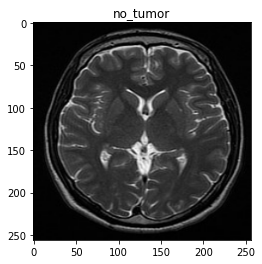

In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

In [8]:
def splitting_dataset_tf(ds, train_split=0.6, val_split=0.2, test_split=0.2, shuffle=True, shuffle_size=10000):
    
    ds_size=len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size=int(train_split * ds_size)
    val_size= int(val_split * ds_size)
    
    train_ds= ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds=splitting_dataset_tf(dataset)

In [10]:
print(len(train_ds),len(val_ds),len(test_ds))

4 1 3


In [11]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size,Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [13]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [14]:
input_shape = (Batch_Size,Image_Size, Image_Size,Channels)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation= 'softmax'),
    
])

model.build(input_shape=input_shape)

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
4/4 [==============================] - 8s 2s/step - loss: 0.9895 - accuracy: 0.5200 - val_loss: 0.7135 - val_accuracy: 0.5600
Epoch 2/50
4/4 [==============================] - 5s 1s/step - loss: 0.6943 - accuracy: 0.5920 - val_loss: 0.8940 - val_accuracy: 0.4400
Epoch 3/50
4/4 [==============================] - 6s 1s/step - loss: 0.7345 - accuracy: 0.5600 - val_loss: 0.7131 - val_accuracy: 0.5600
Epoch 4/50
4/4 [==============================] - 5s 1s/step - loss: 0.6812 - accuracy: 0.5680 - val_loss: 0.6888 - val_accuracy: 0.5520
Epoch 5/50
4/4 [==============================] - 6s 2s/step - loss: 0.6892 - accuracy: 0.5520 - val_loss: 0.6786 - val_accuracy: 0.5840
Epoch 6/50
4/4 [==============================] - 5s 1s/step - loss: 0.6750 - accuracy: 0.5600 - val_loss: 0.6696 - val_accuracy: 0.5600
Epoch 7/50
4/4 [==============================] - 6s 1s/step - loss: 0.6730 - accuracy: 0.5600 - val_loss: 0.6613 - val_accuracy: 0.5600
Epoch 8/50
4/4 [=========================

In [17]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 1s 240ms/step - loss: 0.3167 - accuracy: 0.8640


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

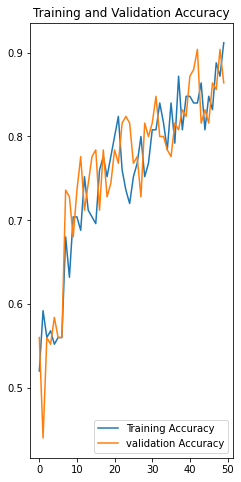

In [19]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
Actual label :  no_tumor
Pred label :  yes_tumor


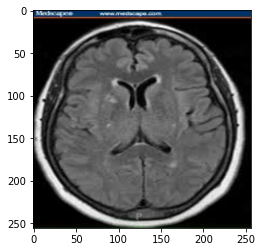

In [20]:
import numpy as np

for image_batch, label_batch in dataset.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual label : ",class_names[first_label])
    
    
    batch_pred = model.predict(image_batch)
    print("Pred label : ",class_names[np.argmax(batch_pred[0])])
    

In [21]:
def pred(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

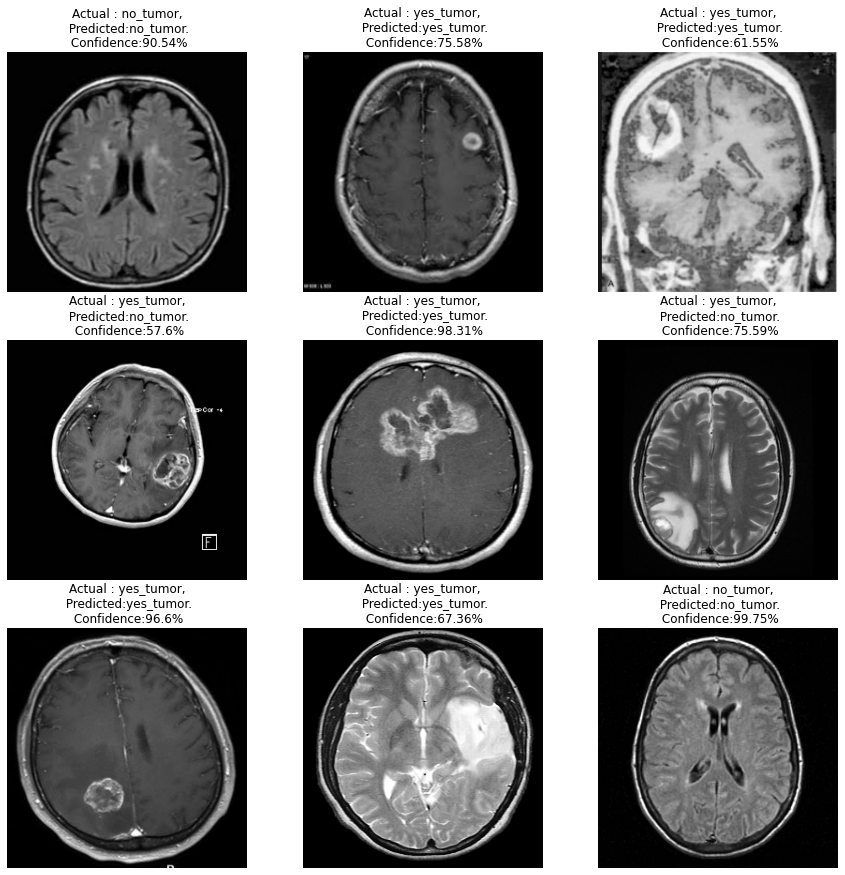

In [22]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = pred(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual : {actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        
        plt.axis("off")

In [23]:
model.save('my_model.h5')

In [24]:
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)       